# Deep Learning

## Assignment 4

### Question 2
### GANs and Diffusion models

Now we will implement a DC-GAN on the CIFAR10 dataset. Let us start by loading the data.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image
from scipy.stats import entropy
from torchvision.models import inception_v3
import torch.nn.functional as F
import math

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
batch_size = 100
epochs = 10
latent_dim = 100
lr = 0.0002
beta1 = 0.5

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


Now let us make the DC-GAN model which will be trained on the CIFAR10 dataset

In [89]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.main(x)
        return x.view(-1, 1)


Now let us train our model.

In [90]:
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

losses_G = []
losses_D = []

In [91]:
real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

for epoch in range(epochs):
    for i, (image, label) in enumerate(dataloader):

        # Discriminator Optimization
        optimizer_D.zero_grad()
        real_output = discriminator(image)
        real_loss = criterion(real_output, real_labels[:len(real_output)])

        noise = torch.randn(batch_size, latent_dim, 1, 1)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data.detach())
        fake_loss = criterion(fake_output, fake_labels[:len(fake_output)])

        total_loss_d = fake_loss + real_loss
        total_loss_d.backward()
        optimizer_D.step()

        #Generator Optimization
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_data)
        gen_loss = criterion(fake_output, real_labels[:len(fake_output)])
        gen_loss.backward()
        optimizer_G.step()

        losses_G.append(gen_loss.item())
        losses_D.append(total_loss_d.item())

        if (i+1)%34 == 0:
            print(f'Epoch [{epoch}/{epochs}], Step [{i+1}/{len(dataloader)}] - Discriminator Loss: {total_loss_d.item():.4f}, Generator Loss: {gen_loss.item():.4f}')

Epoch [0/10], Step [34/782] - Discriminator Loss: 0.1176, Generator Loss: 8.5674
Epoch [0/10], Step [68/782] - Discriminator Loss: 0.1888, Generator Loss: 14.1973
Epoch [0/10], Step [102/782] - Discriminator Loss: 0.5345, Generator Loss: 13.4500
Epoch [0/10], Step [136/782] - Discriminator Loss: 0.6037, Generator Loss: 2.9062
Epoch [0/10], Step [170/782] - Discriminator Loss: 0.2915, Generator Loss: 8.0398
Epoch [0/10], Step [204/782] - Discriminator Loss: 1.0857, Generator Loss: 5.8332
Epoch [0/10], Step [238/782] - Discriminator Loss: 0.2862, Generator Loss: 3.6200
Epoch [0/10], Step [272/782] - Discriminator Loss: 0.7051, Generator Loss: 3.9382
Epoch [0/10], Step [306/782] - Discriminator Loss: 0.4352, Generator Loss: 3.2039
Epoch [0/10], Step [340/782] - Discriminator Loss: 0.7846, Generator Loss: 2.6348
Epoch [0/10], Step [374/782] - Discriminator Loss: 0.7831, Generator Loss: 4.1430
Epoch [0/10], Step [408/782] - Discriminator Loss: 0.3702, Generator Loss: 3.0120
Epoch [0/10], St

Now let us plot the losses.

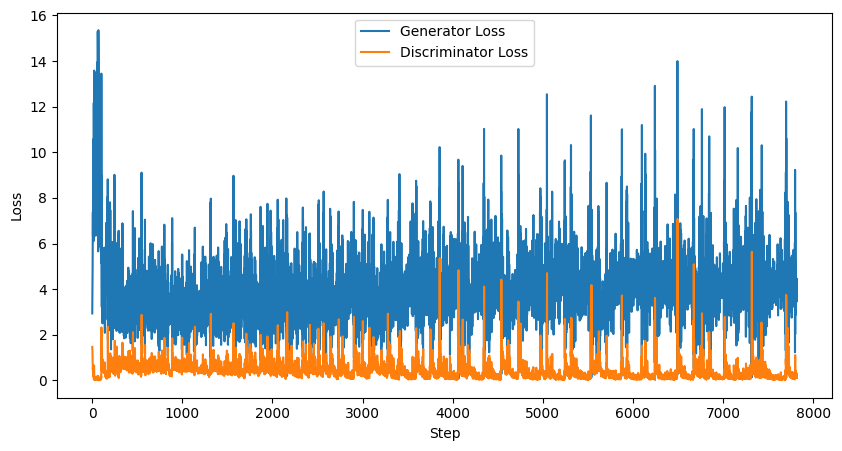

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now let us generate 10 images using the generator that we trained.

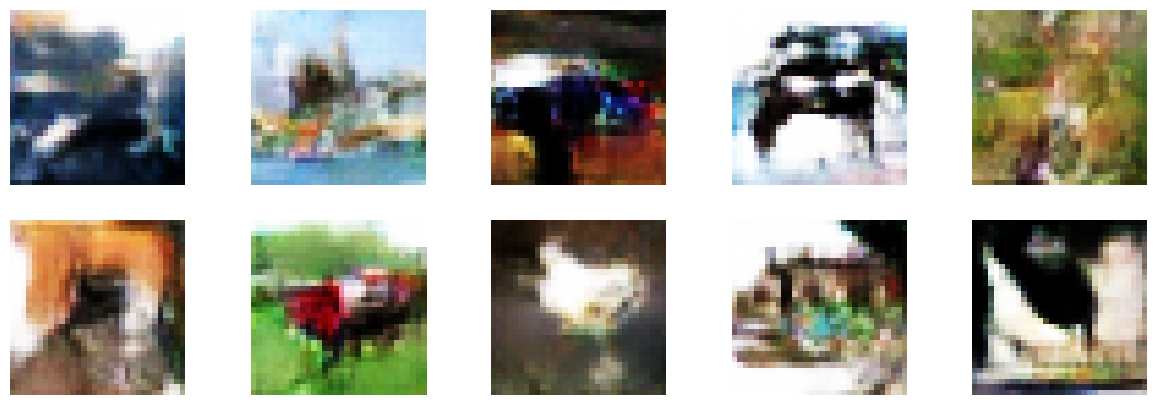

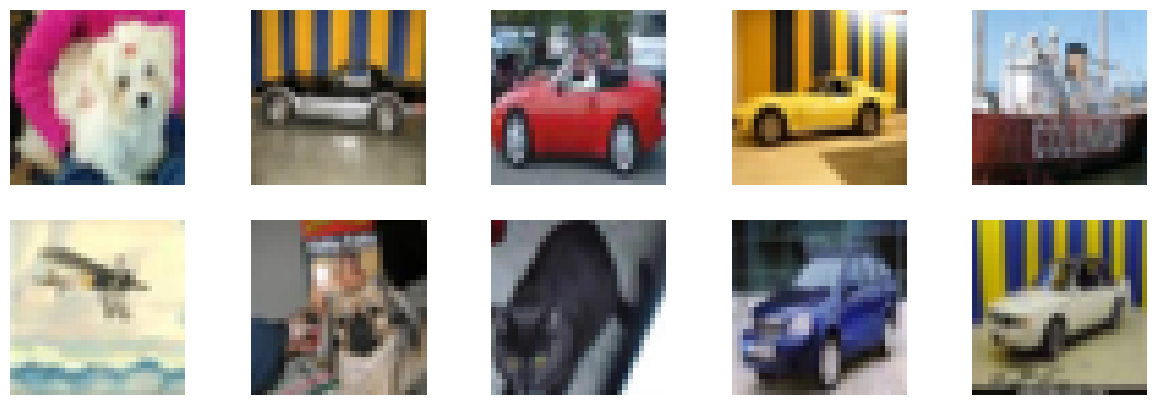

In [134]:
with torch.no_grad():
    z = torch.randn(10, latent_dim, 1, 1)
    images = generator(z)

fig, axes = plt.subplots(2, 5, figsize = (15, 5))

for i, img in enumerate(images):
    img = img.numpy().transpose((1, 2, 0))
    img = 0.5 * img + 0.5
    img = np.clip(img, 0, 1)
    if i < 5:
        x = 0
        y = i
    else:
        x = 1
        y = i - 5


    axes[x, y].imshow(img)
    axes[x, y].axis('off')

X, Y = next(iter(dataloader))
fig, axes = plt.subplots(2, 5, figsize = (15, 5))

for i, img in enumerate(X[:10]):
    img = img.numpy().transpose((1, 2, 0))
    img = 0.5 * img + 0.5
    img = np.clip(img, 0, 1)
    if i < 5:
        x = 0
        y = i
    else:
        x = 1
        y = i - 5


    axes[x, y].imshow(img)
    axes[x, y].axis('off')

Now let us write the function which allows us to calculate the inception scores

In [16]:
def calculate_inception_score(generated_images, num_splits=10):
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()

    transform = transforms.Compose([
        lambda x: transforms.ToPILImage()(x.squeeze(0)),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ])

    scores = []
    batch_size = generated_images.size(0)

    for i in range(num_splits):
        start_idx = i * (batch_size // num_splits)
        end_idx = (i + 1) * (batch_size // num_splits)

        batch = generated_images[start_idx:end_idx]
        batch = transform(batch)

        with torch.no_grad():
            preds = inception_model(batch.unsqueeze(0))

        preds = torch.nn.functional.softmax(preds, dim=1)

        kl_divergence = entropy(torch.Tensor(preds.numpy().mean(axis=0)), axis=0)
        scores.append(kl_divergence)

    inception_score = torch.Tensor(scores).mean()

    return inception_score.item()

In [ ]:
inception_score = calculate_inception_score(images)
print(f'Inception Score is: {inception_score}')

Now let us implement and train a diffusion model. 
### Step 1
### Forward Process

In [4]:
def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,)*(len(x_shape) - 1)))

def forward_diffusion_sample(x_0, t, alphas, one_minus_alphas):
    noise = torch.randn_like(x_0)
    alphas_t = get_index_from_list(alphas, t, x_0.shape)
    one_minus_alpha_t = get_index_from_list(one_minus_alphas, t, x_0.shape)

    return alphas_t*x_0 + one_minus_alpha_t*noise, noise

T = 200
betas = linear_beta_schedule(T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis = 0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alpha_cumprod =torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas*(1. - alphas_cumprod_prev)/(1. - alphas_cumprod)

<class 'torch.Tensor'>


/tmp/ipykernel_5689/1105924137.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize)+1)


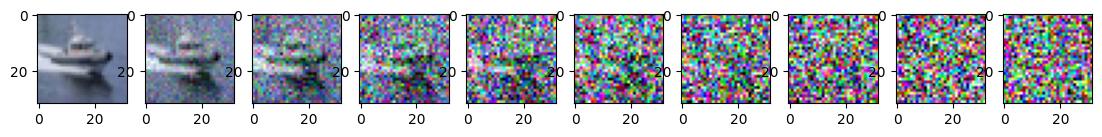

In [5]:
image = next(iter(dataloader))[0][0]
print(type(image))
plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize)+1)
    image, noise = forward_diffusion_sample(image, t, sqrt_alphas_cumprod, sqrt_one_minus_alpha_cumprod)
    image1 = image.numpy().transpose((1, 2, 0))
    image1 = 0.5 * image1 + 0.5
    image1 = np.clip(image1, 0, 1)
    plt.imshow(image1)

### Step 2
### Architecture: U-NET

In [6]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, time, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time, out_channels)
        if up:
            self.conv1 = nn.Conv2d(2*in_channels, out_channels, 3, padding = 1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
            self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.pool = nn.MaxPool2d(3, stride=2)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm(self.relu(self.conv1(x)))

        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., )+(None, )*2]
        h = h+time_emb

        h = self.bnorm(self.relu(self.conv2(h)))

        return self.transform(h)


class SinusoidalPositionalEmbedding(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        embeddings = math.log(10000) / ((self.dim//2)-1)
        embeddings = torch.exp(torch.arange(self.dim//2) * -embeddings)
        embeddings = time[:, None]*embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim = -1)
        return embeddings

class Unet(nn.Module):

    def __init__(self):
        super(Unet, self).__init__()

        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)

        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(3, down_channels[0], 3, padding = 1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], 32) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], 32, up=True) for i in range(len(up_channels) - 1)])

        self.output = nn.Conv2d(up_channels[-1], 3, 1)

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = self.conv0(x)
        residual_input = []

        for down in self.downs:
            x = down(x, t)
            residual_input.append(x)

        for up in self.ups:
            x = torch.cat((x, residual_input.pop()), dim = 1)
            x = up(x, t)

        return self.output(x)

Now that the model has been made, we need to train the model on the data

### Step 3
### Training

First some helper functions to get the loss as well as sample the data and time step.

In [13]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alpha_cumprod)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

# Sampling

@torch.no_grad()
def sample_timestep(model, x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alpha_cumprod_t = get_index_from_list(sqrt_one_minus_alpha_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t*(x - betas_t * model(x, t) / sqrt_one_minus_alpha_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t==0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t)*noise

@torch.no_grad()
def sample_plot_image(model, n_img=1, plot=True):
    img = torch.randn((n_img, 3, 32, 32))
    if plot:
        plt.figure(figsize = (15, 15))
        plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1, ), i, dtype=torch.long)
        img = sample_timestep(model, img, t)
        if i%stepsize == 0 and plot:
            plt.subplot(1, num_images, i/stepsize+1)
            image1 = img.numpy().transpose((1, 2, 0))
            image1 = 0.5 * image1 + 0.5
            image1 = np.clip(image1, 0, 1)
            plt.imshow(image1)
            
    plt.show()
    return img


Now we will train the model.

In [8]:
model = Unet()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 2

for epoch in range(epochs):
    for i, (image, _) in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0,T,(batch_size,)).long()
        loss = get_loss(model, image, t)
        loss.backward()
        optimizer.step()

        if epoch%5 == 0 and i % 10 == 0:
            print(f'Epoch {epoch}/{epochs} | step {i}/{len(dataloader)} | Loss {loss.item()}')

/home/vedansh/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/2 | step 0/500 | Loss 0.8063511252403259
Epoch 0/2 | step 10/500 | Loss 0.5085846781730652
Epoch 0/2 | step 20/500 | Loss 0.426399827003479
Epoch 0/2 | step 30/500 | Loss 0.3574119806289673
Epoch 0/2 | step 40/500 | Loss 0.3157557249069214
Epoch 0/2 | step 50/500 | Loss 0.4846811294555664
Epoch 0/2 | step 60/500 | Loss 0.3293384909629822
Epoch 0/2 | step 70/500 | Loss 0.34735652804374695
Epoch 0/2 | step 80/500 | Loss 0.3078749477863312
Epoch 0/2 | step 90/500 | Loss 0.2760884165763855
Epoch 0/2 | step 100/500 | Loss 0.2707102596759796
Epoch 0/2 | step 110/500 | Loss 0.2876455783843994
Epoch 0/2 | step 120/500 | Loss 0.25959116220474243
Epoch 0/2 | step 130/500 | Loss 0.27157458662986755
Epoch 0/2 | step 140/500 | Loss 0.24212875962257385
Epoch 0/2 | step 150/500 | Loss 0.2516551613807678
Epoch 0/2 | step 160/500 | Loss 0.23110702633857727
Epoch 0/2 | step 170/500 | Loss 0.2120661437511444
Epoch 0/2 | step 180/500 | Loss 0.2516074478626251
Epoch 0/2 | step 190/500 | Loss 0.2123

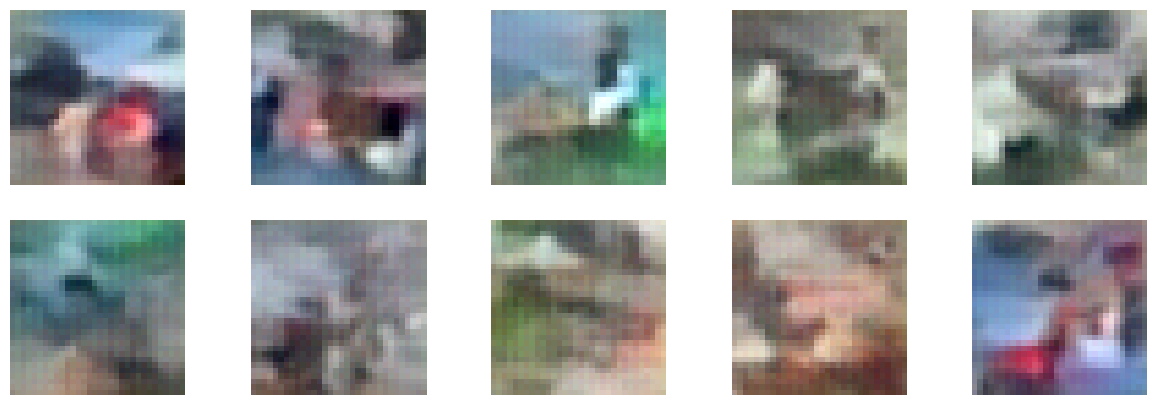

In [14]:
images = sample_plot_image(model, n_img=10, plot=False)
fig, axes = plt.subplots(2, 5, figsize = (15, 5))

for i, img in enumerate(images):
    image1 = img.numpy().transpose((1, 2, 0))
    image1 = 0.5 * image1 + 0.5
    image1 = np.clip(image1, 0, 1)
    if i < 5:
        x = 0
        y = i
    else:
        x = 1
        y = i - 5


    axes[x, y].imshow(image1)
    axes[x, y].axis('off')

Following in the inception score for diffusion models.

In [18]:
inception_score = calculate_inception_score(images)
print(f'Inception Score is: {inception_score}')

Inception Score is: 4.618220329284668
